# SMS SPAM CLASSIFICATION

## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

##  Reading dataset and do preprocessing

In [5]:
df = pd.read_csv(r'spam.csv',encoding='latin-1')

In [6]:
df.head()

v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN

In [7]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of ham and spam messages')

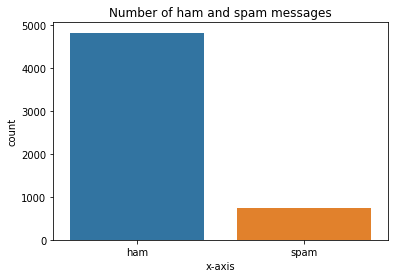

In [9]:
sns.countplot(df.v1)
plt.xlabel('x-axis')
plt.title('Number of ham and spam messages')


### Creating input vectors and process labels

In [10]:
X = df.v2
Y = df.v1

In [11]:
le = LabelEncoder()
Y = le.fit_transform(Y)

In [12]:
Y = Y.reshape(-1,1)

## Split the training and testing data

In [13]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.20)

## Process the data

In [14]:
max_words = 1000
max_len = 150

In [15]:
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)


In [16]:
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

## Creating the model and adding layers

In [17]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(128)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('tanh')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [18]:
model = RNN()

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 FC1 (Dense)                 (None, 256)               33024     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

In [20]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy','mse','mae'])

## Fit the model

In [21]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=100,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/100
28/28 [==============================] - 18s 523ms/step - loss: 0.3450 - accuracy: 0.8836 - mse: 0.0875 - mae: 0.1576 - val_loss: 0.1204 - val_accuracy: 0.9809 - val_mse: 0.0285 - val_mae: 0.1097
Epoch 2/100
28/28 [==============================] - 13s 475ms/step - loss: 0.0936 - accuracy: 0.9818 - mse: 0.0223 - mae: 0.0968 - val_loss: 0.0494 - val_accuracy: 0.9877 - val_mse: 0.0171 - val_mae: 0.0816


In [22]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [24]:
acc = model.evaluate(test_sequences_matrix,Y_test)

35/35 [==============================] - 3s 72ms/step - loss: 0.0974 - accuracy: 0.9839 - mse: 0.0187 - mae: 0.0811


In [25]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc[0],acc[1]))

Test set
  Loss: 0.097
  Accuracy: 0.984


## Saving the model

In [26]:
model.save('spam.h5')

## Testing the model

In [27]:
from tensorflow.keras.models import load_model
m = load_model('spam.h5')

In [28]:
m.evaluate(test_sequences_matrix, Y_test)

35/35 [==============================] - 3s 70ms/step - loss: 0.0974 - accuracy: 0.9839 - mse: 0.0187 - mae: 0.0811


[0.09738346934318542,
 0.9838564991950989,
 0.01870471052825451,
 0.08109962940216064]